Use dataset generated from previous notebook. Change the location(7-line) of dataset according to your dataset location

0
31900
31100
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
1
31300
30700
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
2
32000
31600
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
3
32100
32100
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
4
32800
31600
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
5
32600
31500
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
6
32200
31400
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
7
32700
32300
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
8
32600
32700
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also

<AxesSubplot:>

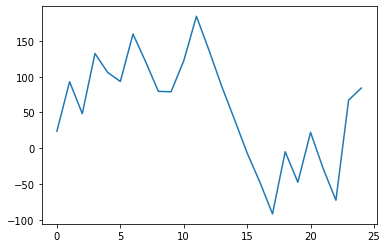

In [6]:
#import libraries
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dateutil.relativedelta import relativedelta, TH

#fetch all the files from the diretory
path = pd.DataFrame(glob(r'C:\Users\deepe\OneDrive\Desktop\NLP\New folder\*'),columns=['location'])
path['data_date'] = path['location'].apply(lambda x: x.split('_')[-1].split('.')[0])
path['data_date'] = path['data_date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
path = path.sort_values(['data_date'])
path.reset_index(drop=True,inplace=True)

intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','Days_to_Expiry','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])

for index, row in path.iterrows():
    
    try:
        print(index)
        

        data = pd.read_parquet(row['location'])
        
       
        
        #change the entry and exit time according to the requirements  
        #In this case it is 9:19 am and 3:15 pm 
        a = datetime.time(9,19)
        b = datetime.time(15,15)
        entry_datetime = datetime.datetime.combine(row['data_date'].date(),a)
        exit_datetime = datetime.datetime.combine(row['data_date'].date(),b)
        


        #I-CurrentMonth
        #II-NextMonth
        #III-NextToNextMonth
        data['expiry_type'] = np.where((data['instrument_type'] == 'FUT'),data['ticker'].apply(lambda x: x.split('-')[-1].split('.')[0]),'')

        future_expiry_offset = 'I'
        instrument = 'BANKNIFTY'
        base = 100

        futures_data = data[(data['instrument_type'] == 'FUT') & (data['instrument_name'] == instrument) & (data['expiry_type'] == future_expiry_offset)]
        futures_data.reset_index(drop=True,inplace=True)

       
    
    
     
        nearest_expiry = row['data_date'].date() + relativedelta(weekday=TH(+1))
        
        pseudo_data = data[(data['instrument_name'] == 'BANKNIFTY') & (data['datetime'] == entry_datetime) & (data['instrument_type'] == 'CE') & (data['expiry_date']== nearest_expiry)]

        # find the index of strike price whose price is near 150 Rs 
        pseudo_index= pseudo_data['close'].sub(150).abs().idxmin()
        
        #get the strike price 
        atm = pseudo_data['strike_price'].loc[pseudo_index]
        expiry_ce = pseudo_data['expiry_date'].loc[pseudo_index]

        #loc and iloc issue 
        
        #this 27263 is not readable convert it into base terms as strike price are in gap of 100 
        atm = base*round(atm/base) 
        print(atm)
    
        
        
        

        ce_data = data[(data['instrument_type'] == 'CE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == expiry_ce)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm)]
        ce_data.reset_index(drop=True,inplace=True)
        
        
        pseudo_data1 = data[(data['instrument_name'] == 'BANKNIFTY') & (data['datetime'] == entry_datetime) & (data['instrument_type'] == 'PE') & (data['expiry_date']== nearest_expiry) ]
        
        # find the index of strike price whose price is near 150 Rs 
        pseudo_index1= pseudo_data1['close'].sub(150).abs().idxmin()
        
        #get the strike price 
        atm1 = pseudo_data1['strike_price'].loc[pseudo_index1]
        expiry1 = pseudo_data1['expiry_date'].loc[pseudo_index1]
        #this 27263 is not readable convert it into base terms as strike price are in gap of 100 
        atm1 = base*round(atm1/base)
        print(atm1)
        
        
        pe_data = data[(data['instrument_type'] == 'PE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == expiry1)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm1)]
        pe_data.reset_index(drop=True,inplace=True)

        ce_symbol = ce_data['ticker'].iloc[0]
        pe_symbol = pe_data['ticker'].iloc[0]
        

        futures_data = futures_data[['datetime','close']].set_index('datetime')
        ce_data = ce_data[['datetime','close','high']].set_index('datetime')
        pe_data = pe_data[['datetime','close','high']].set_index('datetime')
        
        
        intraday_data = pd.concat([futures_data,ce_data,pe_data],axis=1)
        
        intraday_data.columns = ['futures_close','ce_close','ce_high','pe_close','pe_high']
        intraday_data = intraday_data.ffill()

        #pd.set_option('display.max_rows',400)

        intraday_data.reset_index(inplace=True)

        traded_prices = intraday_data[intraday_data['datetime'] == entry_datetime]

        futures_entry_price = traded_prices['futures_close'].iloc[0]
        ce_entry_price = traded_prices['ce_close'].iloc[0]
        pe_entry_price = traded_prices['pe_close'].iloc[0]

        stop_loss_percentage = 30/100 #change the percentage according to the requirements 

        ce_stop_loss = ce_entry_price + ce_entry_price*stop_loss_percentage
        
        
        #changed
        pe_stop_loss = pe_entry_price + pe_entry_price*stop_loss_percentage

        entry_time_index = intraday_data[intraday_data['datetime'] == entry_datetime].index[0]

        exit_time_index = intraday_data[intraday_data['datetime'] == exit_datetime].index[0]

        intraday_data = intraday_data[entry_time_index:exit_time_index+1]

        intraday_data['ce_pnl'] = 0
        intraday_data['pe_pnl'] = 0

        intraday_data.reset_index(drop=True,inplace=True)

        ce_stop_loss_counter = 0
        pe_stop_loss_counter = 0
        ce_exit_datetime = ''
        pe_exit_datetime = ''
        ce_exit_price = 0
        pe_exit_price = 0
        ce_pnl = 0
        pe_pnl = 0
        pnl = 0
        
        

        for index, row in intraday_data.iterrows():
            
            ce_ltp = row['ce_high']
            pe_ltp = row['pe_high']
            

            #criterias for exit
            #none of the stoplosses were hit and time limit is reached
            if (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0) & (row['datetime'] == exit_datetime):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1
                pe_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']
                pe_exit_datetime = row['datetime']

                ce_exit_price = ce_ltp
                pe_exit_price = pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('none of the stoplosses were hit and time limit is reached')

                pnl = ce_pnl + pe_pnl

                break

            #ce stop loss is hit and none were hit till now
            elif (ce_ltp >= ce_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_stop_loss
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']

                ce_exit_price = ce_stop_loss
                
                #if one stoploss is hit then change the other one to its selling price 
                pe_stop_loss = pe_entry_price

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('ce stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #pe stop loss is hit and none were hit till now
            elif (pe_ltp >= pe_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_stop_loss

                pe_stop_loss_counter = 1

                pe_exit_datetime = row['datetime']
                
                
                #if one stoploss is hit then change the other one to its selling price 
                ce_stop_loss = ce_entry_price

                pe_exit_price = pe_stop_loss

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('pe stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0):

                if (pe_ltp >= pe_stop_loss) & (row['datetime'] < exit_datetime):

                    pe_pnl = pe_entry_price - pe_stop_loss

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_stop_loss

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    pe_pnl = pe_entry_price - pe_ltp

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_ltp

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1):

                if (ce_ltp >= ce_stop_loss) & (row['datetime'] < exit_datetime):

                    ce_pnl = ce_entry_price - ce_stop_loss

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_stop_loss

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    ce_pnl = ce_entry_price - ce_ltp

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_ltp

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #update the pnl during the normal course of the day
            elif (((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0))  | ((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 1))) or row['datetime'] <= exit_datetime:

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                pnl = ce_pnl + pe_pnl

        intraday_trade_log = intraday_trade_log.append({'Entry_Datetime':entry_datetime,
                                                        'Future_Traded_Price':futures_entry_price,
                                                        'ATM':atm,
                                                        'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                                        'CE_Symbol':ce_symbol,
                                                        'CE_Entry_Price':ce_entry_price,
                                                        'CE_Exit_Price':ce_exit_price,
                                                        'CE_Exit_Datetime':ce_exit_datetime,
                                                        'PE_Symbol':pe_symbol,
                                                        'PE_Entry_Price':pe_entry_price,
                                                        'PE_Exit_Price':pe_exit_price,
                                                        'PE_Exit_Datetime':pe_exit_datetime,
                                                        'PnL':pnl},ignore_index=True)
    except Exception as e:
        
        print(e)
        print(row['location'])

intraday_trade_log['PnL'].cumsum().plot()

In [2]:
# only run this if you want to generate a csv file 
intraday_trade_log.to_csv('backtest-final.csv')

PermissionError: [Errno 13] Permission denied: 'backtest-final.csv'

In [7]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol,CE_Entry_Price,CE_Exit_Price,CE_Exit_Datetime,PE_Symbol,PE_Entry_Price,PE_Exit_Price,PE_Exit_Datetime,PnL
0,2021-01-04 09:19:00,31530.00,31900,3,BANKNIFTY07JAN2131900CE,154.60,82.750,2021-01-04 15:15:00,BANKNIFTY07JAN2131100PE,160.00,208.000,2021-01-04 10:48:00,23.850
1,2021-01-05 09:19:00,31077.65,31300,2,BANKNIFTY07JAN2131300CE,163.00,211.900,2021-01-05 09:29:00,BANKNIFTY07JAN2130700PE,158.90,40.900,2021-01-05 15:15:00,69.100
2,2021-01-06 09:19:00,31908.00,32000,1,BANKNIFTY07JAN2132000CE,148.80,193.440,2021-01-06 12:29:00,BANKNIFTY07JAN2131600PE,135.40,135.400,2021-01-06 13:48:00,-44.640
3,2021-01-07 09:19:00,32179.45,32100,0,BANKNIFTY07JAN2132100CE,123.45,0.500,2021-01-07 15:15:00,BANKNIFTY07JAN2132100PE,129.65,168.545,2021-01-07 10:06:00,84.055
4,2021-01-08 09:19:00,32243.70,32800,6,BANKNIFTY14JAN2132800CE,142.25,123.600,2021-01-08 15:15:00,BANKNIFTY14JAN2131600PE,150.25,195.325,2021-01-08 13:39:00,-26.425
5,2021-01-11 09:19:00,32133.00,32600,3,BANKNIFTY14JAN2132600CE,158.75,128.200,2021-01-11 15:15:00,BANKNIFTY14JAN2131500PE,144.00,187.200,2021-01-11 10:20:00,-12.650
6,2021-01-12 09:19:00,31848.60,32200,2,BANKNIFTY14JAN2132200CE,158.45,205.985,2021-01-12 09:40:00,BANKNIFTY14JAN2131400PE,157.75,43.950,2021-01-12 15:15:00,66.265
7,2021-01-13 09:19:00,32563.50,32700,1,BANKNIFTY14JAN2132700CE,129.75,168.675,2021-01-13 09:34:00,BANKNIFTY14JAN2132300PE,153.55,153.550,2021-01-13 10:35:00,-38.925
8,2021-01-14 09:19:00,32729.30,32600,0,BANKNIFTY14JAN2132600CE,137.10,178.230,2021-01-14 09:22:00,BANKNIFTY14JAN2132700PE,150.60,150.600,2021-01-14 09:29:00,-41.130
9,2021-01-15 09:19:00,32550.00,33200,6,BANKNIFTY21JAN2133200CE,151.60,104.000,2021-01-15 15:15:00,BANKNIFTY21JAN2131800PE,160.85,209.105,2021-01-15 09:35:00,-0.655


In [ ]:
pwd